## Introductory Machine Learning: Assignment 7

**Deadline:**

Assignment 7 is due Thursday, December 9 at 11:59pm. Late work will not be accepted as per the course policies (see the Syllabus and Course policies on [Canvas](https://canvas.yale.edu).

Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged.

You should start early so that you have time to get help if you're stuck. The drop-in office hours schedule can be found on [Canvas](https://canvas.yale.edu).  You can also post questions or start discussions on [Ed Discussion](https://edstem.org/us/courses/9209/discussion/). The problems are broken up into steps that should help you to make steady progress.

**Submission:**

Submit your assignment as a .pdf on Gradescope, and as a .ipynb on Canvas. You can access Gradescope through Canvas on the left-side of the class home page. The problems in each homework assignment are numbered. Note: When submitting on Gradescope, please select the correct pages of your pdf that correspond to each problem. This will allow graders to find your complete solution to each problem.

To produce the .pdf, please do the following in order to preserve the cell structure of the notebook:  
1.  Go to "File" at the top-left of your Jupyter Notebook
2.  Under "Download as", select "HTML (.html)"
3.  After the .html has downloaded, open it and then select "File" and "Print" (note you will not actually be printing)
4.  From the print window, select the option to save as a .pdf

**Topics**
1. Neural networks
2. Classification
3. Reinforcement learning

## Problem 1: From Batch to SGD (25 points)

In class, we discussed a "bare bones" implementation of a 2-layer neural network for classification, using rectified linear units as activation functions. 
This implementation only uses the `numpy` package.

You've worked hard this semester and have made great progress on your Python coding skills. Now it's time to put these skills to work! Your task in this part of the assigment is to modify the training algorithm from batch gradient descent to stochastic gradient descent, and to experiment with some different settings of the parameters. 


### Neural networks for classification (batch gradient descent)

We use $H_{1}$  to denote the number of hidden units, and $D$  to be the dimension of the input  $X$, and $K$  to be the number of classes. For the spiral data implemented in the code, we have  $D=2$  and  $K=3$. The two-layer network has the form

\begin{aligned}
    h_{1} &=\operatorname{ReLU}\left(W_{1} X+b_{1}\right) \\
    p &=\operatorname{Softmax}\left(W_{2} h_{1}+b_{2}\right).
\end{aligned}

Here the parameters of the network are  $W_{1} \in \mathbb{R}^{H_{1} \times D}$, $b_{1} \in \mathbb{R}^{H_{1}}$, $W_{2} \in \mathbb{R}^{K \times H_{1}}$, $b_{2} \in \mathbb{R}^{K}$. Recall that ReLU is the "rectified linear unit"  $\operatorname{ReLU}(x)=\max \{0, x\}$  applied componentwise, and Softmax maps a $K$-vector to the probability simplex according to
$$
    \operatorname{Softmax}(v)_{i}=\frac{\exp \left(v_{i}\right)}{\sum_{j=1}^{K} \exp \left(v_{j}\right)}.
$$

This can be thought of as a nonlinear logistic regression model $p(Y=k \mid X)$  for  $k=1,2, \ldots, K$. For a given training set  $\left\{\left(X_{i}, Y_{i}\right)\right\}_{i=1}^{n}$, we use the loss function
$$
    \mathcal{L}= - \frac{1}{n} \sum_{i=1}^{n}\log p\left(Y=Y_{i} \mid X_{i}\right).
$$


In [61]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['axes.facecolor'] = 'lightgray'

Here are some helper functions. Don't modify, just run this cell

In [62]:
def generate_spirals(N=100, K=3, noise=0.3):
    D = 2  # dimensionality
    X = np.zeros((N*K, D))
    y = np.zeros(N*K, dtype='uint8')
    for j in range(K):
        ix = range(N*j, N*(j+1))
        r = np.linspace(0.0, 1, N)  # radius
        t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*noise  
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    return X, y

def plot_data(X, y):
    fig = plt.figure()
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(np.min(X[:,0])-.1, np.max(X[:,0])+.1)
    plt.ylim(np.min(X[:,1])-.1, np.max(X[:,1])+.1)

    
def plot_classifier(X, y, W1, b1, W2, b2):
    h = 0.015
    x_min, x_max = X[:, 0].min() - .2, X[:, 0].max() + .2
    y_min, y_max = X[:, 1].min() - .2, X[:, 1].max() + .2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = np.dot(np.maximum(
        0, np.dot(np.c_[xx.ravel(), yy.ravel()], W1) + b1), W2) + b2
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

def evaluate_accuracy(X, y, W1, b1, W2, b2):
    hidden_layer = np.maximum(0, np.dot(X, W1) + b1)
    scores = np.dot(hidden_layer, W2) + b2
    predicted_class = np.argmax(scores, axis=1)
    percent_correct = 100*np.mean(predicted_class == y)
    return percent_correct

First we generate spiral data.

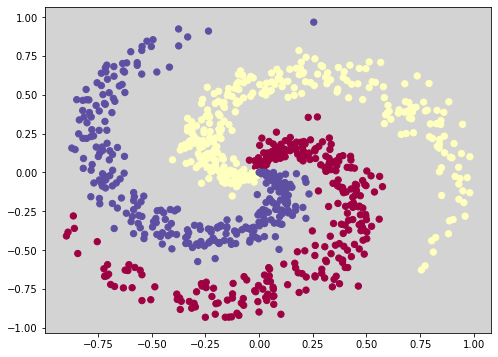

In [63]:
X_spiral, y_spiral = generate_spirals(N=300, K=3)
X_spiral_test, y_spiral_test = generate_spirals(N=300, K=3)
plot_data(X_spiral, y_spiral)    

Our goal is to train a 2-layer neural network that is able to accurately classify the data.  Here we provide a starter code that implements a *batch* gradient descent algorithm. Just run the cell below to train the model.

In [71]:
# You should not modify the code in this cell

# train 2-layer network using batch gradient descent
def train_2_layer_network_batch(X, y, H1=100, steps=10000):

    D = X.shape[1]
    K = len(set(y))

    # initialize parameters randomly
    # size of hidden layer H1 = 100
    W1 = np.random.randn(D, H1)
    b1 = np.zeros((1, H1))
    W2 = np.random.randn(H1, K)
    b2 = np.zeros((1, K))
    loss = []

    # some hyperparameters
    step_size = 1e-1

    # gradient descent loop
    num_examples = X.shape[0]
    for i in tqdm(range(steps)):

        # evaluate class scores, [N x K]
        # note, ReLU activation
        hidden_layer = np.maximum(0, np.dot(X, W1) + b1)
        scores = np.dot(hidden_layer, W2) + b2

        # compute the class probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)  # [N x K]

        # compute the loss: minus log prob
        correct_logprobs = -np.log(probs[range(num_examples), y])
        this_loss = np.sum(correct_logprobs) / num_examples
        loss.append(this_loss)

        # compute the gradient on scores
        dscores = np.array(probs)
        dscores[range(num_examples), y] -= 1
        dscores /= num_examples

        # backpropate the gradient to the parameters
        # first backprop into parameters W2 and b2
        dW2 = np.dot(hidden_layer.T, dscores)
        db2 = np.sum(dscores, axis=0, keepdims=True)
        # next backprop into hidden layer
        dhidden = np.dot(dscores, W2.T)
        # backprop the ReLU non-linearity
        dhidden[hidden_layer <= 0] = 0
        # finally into W,b
        dW1 = np.dot(X.T, dhidden)
        db1 = np.sum(dhidden, axis=0, keepdims=True)

        # perform a parameter update
        W1 += -step_size * dW1
        b1 += -step_size * db1
        W2 += -step_size * dW2
        b2 += -step_size * db2

    return W1, b1, W2, b2, loss


Now we train a 2-layer neural net on the spiral data:

100%|██████████| 10000/10000 [00:42<00:00, 235.29it/s]


Text(0, 0.5, 'Loss')

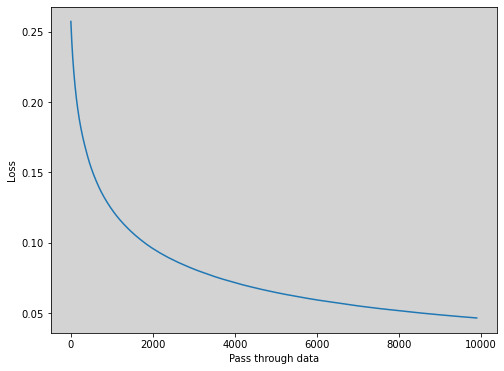

In [65]:
W1, b1, W2, b2, loss = train_2_layer_network_batch(X_spiral, y_spiral, H1=100, steps=10000)

plt.plot(loss[100:])
plt.xlabel('Pass through data')
plt.ylabel('Loss')

Next we evaluate the network on the training and test data. Notice that the training accuracy is high even though the neural network has only 2 layers and hidden width $H=100$.

In [66]:
training_accuracy = evaluate_accuracy(X_spiral, y_spiral, W1, b1, W2, b2)
print('Training accuracy: %.2f%%' % training_accuracy)
    
test_accuracy = evaluate_accuracy(X_spiral_test, y_spiral_test, W1, b1, W2, b2)
print('Test accuracy: %.2f%%' % test_accuracy)


Training accuracy: 99.67%
Test accuracy: 98.89%


Now we can plot the decision boundaries of the trained network, to visualize the resulting classifier. We see that the decision boundaries are pretty good!

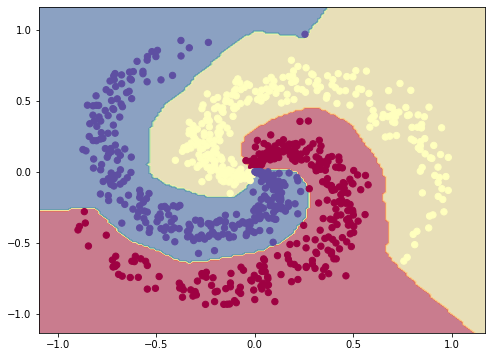

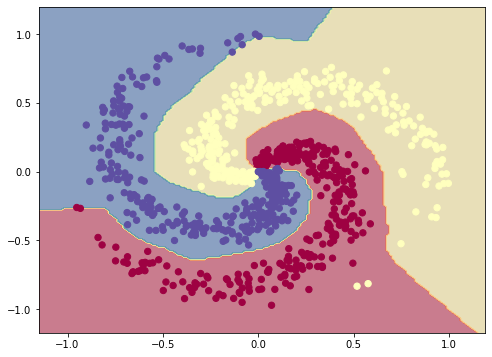

In [67]:
# plot the resulting classifier
plot_classifier(X_spiral, y_spiral, W1, b1, W2, b2)
plot_classifier(X_spiral_test, y_spiral_test, W1, b1, W2, b2)

Before answering the following questions, please make sure that you understand what each line of the starter code does. Feel free to reuse the starter code for the following problems.

### Problem 1.1: Modify the code to use SGD

Run the code above and inspect it to be sure you understand how it works. Then, rewrite the code by writing a function that implements an SGD version. Your function declaration should look like this:

```python
def train_2_layer_network_SGD(X, y, H1, step_size, T)
```    

where `X` is the training data, `y` is the training label, `H1` is the number of hidden units in the first layer, `step_size` is the step size used for stochastic gradient descent, and `T` is the total number of SGD training steps. Your function should return the trained network parameters and the cumulative average loss

$$
    \mathcal{L}_t= - \frac{1}{t} \sum_{i=1}^{t}\log p\left(Y=Y_{i} \mid X_{i}\right)
$$

Then train the network and display the loss and classification results in your notebook, as is done for the network in the starter code.

In [68]:
# You should not modify the code in this cell

# train 2-layer network using batch gradient descent
def train_2_layer_network_sgd(X, y, H1=100, step_size=1e-4, T=200000):

    D = X.shape[1]
    K = len(set(y))

    # initialize parameters randomly
    # size of hidden layer H1 = 100
    W1 = np.random.randn(D, H1)
    b1 = np.zeros((1, H1))
    W2 = np.random.randn(H1, K)
    b2 = np.zeros((1, K))
    loss = []

    # some hyperparameters

    # gradient descent loop
    num_examples = X.shape[0]
    for i in range(T):
        n = np.random.choice(num_examples)
        X_n = np.zeros((1, 2))
        X_n[0] = X[n]
        # evaluate class scores, [N x K]
        # note, ReLU activation
        hidden_layer = np.maximum(0, np.dot(X_n, W1) + b1)
        scores = np.dot(hidden_layer, W2) + b2

        # compute the class probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores)  # [N x K]

        # compute the loss: minus log prob


        # compute the gradient on scores
        dscores = np.array(probs)
        dscores[0, y[n]] -= 1

        # backpropate the gradient to the parameters
        # first backprop into parameters W2 and b2
        dW2 = np.dot(hidden_layer.T, dscores)
        db2 = np.sum(dscores, axis=0, keepdims=True)
        # next backprop into hidden layer
        dhidden = np.dot(dscores, W2.T)
        # backprop the ReLU non-linearity
        dhidden[hidden_layer <= 0] = 0
        # finally into W,b
        dW1 = np.dot(X_n.T, dhidden)
        db1 = np.sum(dhidden, axis=0, keepdims=True)

        # perform a parameter update
        W1 += -step_size * dW1
        b1 += -step_size * db1
        W2 += -step_size * dW2
        b2 += -step_size * db2
        
        hidden_layer = np.maximum(0, np.dot(X, W1) + b1)
        scores = np.dot(hidden_layer, W2) + b2
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)  # [N x K]
        correct_logprobs = -np.log(probs[range(num_examples), y])
        this_loss = np.sum(correct_logprobs) / num_examples
        loss.append(this_loss)
        
    return W1, b1, W2, b2, loss


### Problem 1.2: Run on spiral data

Train and evaluate your model on the spiral data. Just evaluate the following cells, 
no need to change them. This will verify that your code is working correctly.

Text(0, 0.5, 'Cumulative loss')

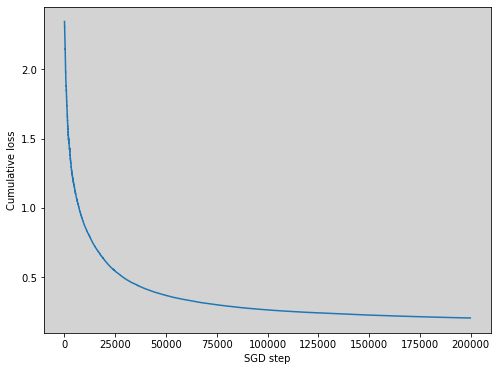

In [70]:
W1, b1, W2, b2, loss = train_2_layer_network_sgd(X_spiral, y_spiral, H1=100, step_size=1e-4, T=200000)

plt.plot(loss[100:])
plt.xlabel('SGD step')
plt.ylabel('Cumulative loss')

Evaluate the training accuracy of your SGD trained model on the spiral dataset.

In [72]:
training_accuracy = evaluate_accuracy(X_spiral, y_spiral, W1, b1, W2, b2)
print('Training accuracy: %.2f%%' % training_accuracy)
    
test_accuracy = evaluate_accuracy(X_spiral_test, y_spiral_test, W1, b1, W2, b2)
print('Test accuracy: %.2f%%' % test_accuracy)



Training accuracy: 96.56%
Test accuracy: 96.56%


Finally, plot the decision boundary of your trained network on the training and test data. 

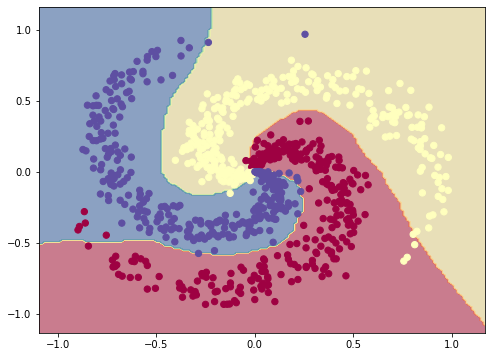

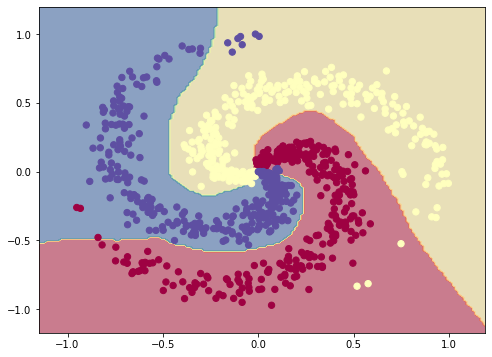

In [73]:
plot_classifier(X_spiral, y_spiral, W1, b1, W2, b2)
plot_classifier(X_spiral_test, y_spiral_test, W1, b1, W2, b2)

### Problem 1.3: Run on circles data

In the next two problems we'll use two other toy examples generated by scikit-learn package. You are to apply some 2-layer neural networks with stochastic gradient descent to learn the patterns, similar to what you did in Problem 1.2. 

The first toy dataset forms two concentered circles with different radius, and we add a little bit of noise so that two circles start mixing together. Use your `train_2_layer_network_SGD` function on this dataset `X_circles` and `y_circles`. Tweak the parameters of the function, compare a few different possibilities, and find the set of tuning parameters that gives good  evaluation accuracy on the training and test. Draw the decision boundaries of your best classifier.

Try different hidden widths `H1`, learning rate, and perhaps different training times. *Only present the result for one setting of the parameters that you choose.*

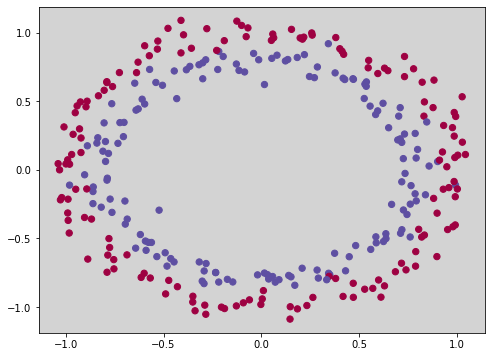

In [74]:
from sklearn import datasets

# generate circles
X_circles, y_circles = datasets.make_circles(300, noise=0.06, random_state=265)
X_circles_test, y_circles_test = datasets.make_circles(300, noise=0.06, random_state=565)

plot_data(X_circles, y_circles)


Text(0, 0.5, 'Cumulative loss')

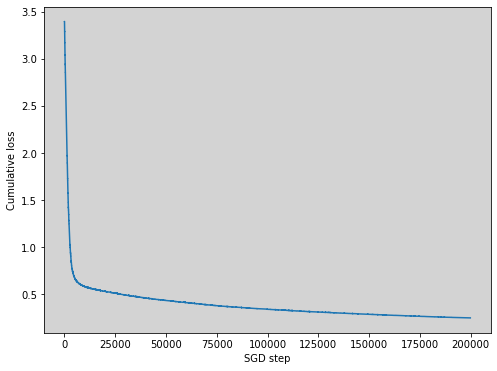

In [75]:
W1, b1, W2, b2, loss = train_2_layer_network_sgd(X_circles, y_circles, H1=100, step_size=1e-4, T=200000)

plt.plot(loss[100:])
plt.xlabel('SGD step')
plt.ylabel('Cumulative loss')

In [ ]:
training_accuracy = evaluate_accuracy(X_circles, y_circles, W1, b1, W2, b2)
print('Training accuracy: %.2f%%' % training_accuracy)
    
test_accuracy = evaluate_accuracy(X_circles_test, y_circles_test, W1, b1, W2, b2)
print('Test accuracy: %.2f%%' % test_accuracy)

Training accuracy: 96.33%
Test accuracy: 94.33%


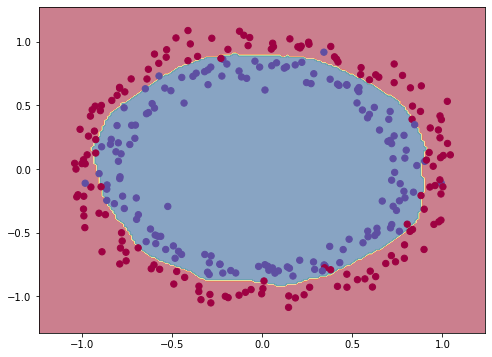

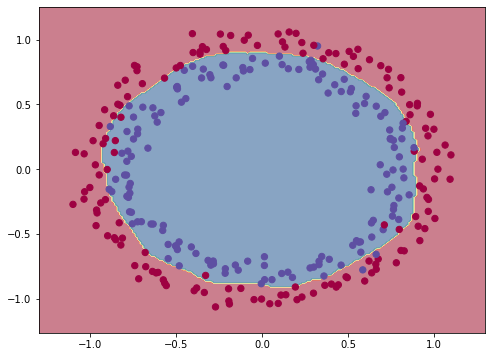

In [77]:
plot_classifier(X_circles, y_circles, W1, b1, W2, b2)
plot_classifier(X_circles_test, y_circles_test, W1, b1, W2, b2)

### Problem 1.4: Run on blobs data

In this problem we'll use the "blobs" data, which are just Gaussians. 
As above, train some 2-layer neural networks with stochastic gradient descent to learn the patterns, by trying different hidden widths `H1`, learning rate, and perhaps different training times.
*Only present the result for one setting of the parameters that you choose.*

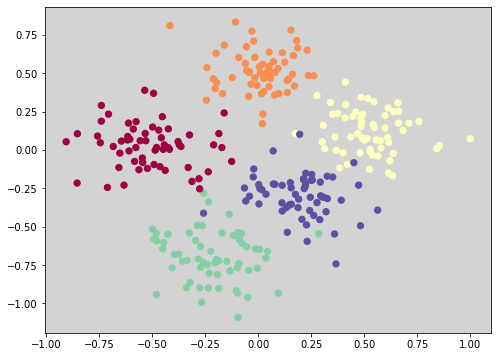

In [78]:
# generate blobs
centers = np.array([[-.5,.0],[0,.5], [.5,.1], [-.2, -.7], [.2, -.3]])
X_blobs, y_blobs = datasets.make_blobs(300, centers=centers, cluster_std=.15, center_box=(-1.0, 1.0), random_state=265)
X_blobs_test, y_blobs_test = datasets.make_blobs(300, centers=centers, cluster_std=.15, center_box=(-1.0, 1.0), random_state=565)

plot_data(X_blobs, y_blobs)


In [ ]:
W1, b1, W2, b2, loss = train_2_layer_network_sgd(X_blobs, y_blobs, H1=100, step_size=1e-4, T=200000)

plt.plot(loss[100:])
plt.xlabel('SGD step')
plt.ylabel('Cumulative loss')

In [ ]:
training_accuracy = evaluate_accuracy(X_blobs, y_blobs, W1, b1, W2, b2)
print('Training accuracy: %.2f%%' % training_accuracy)
    
test_accuracy = evaluate_accuracy(X_blobs_test, y_blobs_test, W1, b1, W2, b2)
print('Test accuracy: %.2f%%' % test_accuracy)

Training accuracy: 97.67%
Test accuracy: 94.67%


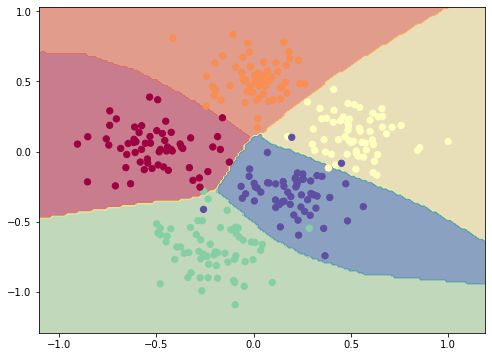

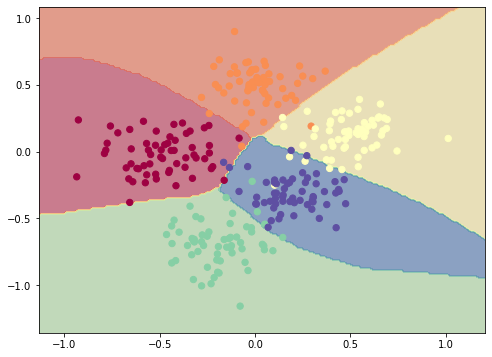

In [ ]:
plot_classifier(X_blobs, y_blobs, W1, b1, W2, b2)
plot_classifier(X_blobs_test, y_blobs_test, W1, b1, W2, b2)

### Problem 1.4: Overfitting

Given the high accuracies on both training and test sets, we may naturally ask
if the neural networks can overfit. Choose one of the three data sets above: Spirals, circles, or blobs. Using this data, try to train a model to intentionally overfit. How do you get the model to overfit? Explain and comment on the bias-variance tradeoff.

In [82]:
W1, b1, W2, b2, loss = train_2_layer_network_sgd(X_blobs, y_blobs, H1=10000, step_size=1e-4, T=200000)

plt.plot(loss[100:])
plt.xlabel('SGD step')
plt.ylabel('Cumulative loss')

In [ ]:
training_accuracy = evaluate_accuracy(X_blobs, y_blobs, W1, b1, W2, b2)
print('Training accuracy: %.2f%%' % training_accuracy)
    
test_accuracy = evaluate_accuracy(X_blobs_test, y_blobs_test, W1, b1, W2, b2)
print('Test accuracy: %.2f%%' % test_accuracy)

Training accuracy: 98.00%
Test accuracy: 95.00%


We can get the model to overfit by adding more layers, increasing the nodes number per layer or increasing the training epoch. They all make the model more flexible to decrease the bias, but increase the variance.  


<img src="https://upload.wikimedia.org/wikipedia/commons/5/53/Lake_Baikal_in_winter.jpg" width=300 style="padding: 10px; float: right;">


## Problem 2: Frozen Lake (25 points)

In class we introduce the Q-learning algorithm using the Taxi problem from the OpenAI `gym` package. In this problem we will explore another toy reinforcement learning problem, called  "Frozen Lake". In this problem you need to walk over a grid that represents a partially frozen lake, being careful not to fall through holes in the ice. (The author of this problem fell through the ice in a frozen lake when he was a kid&mdash;at night! It was quite an experience...) The environment is a simple 4x4 grid, and the goal is to walk from one corner to the other without falling through.

Unlike the Taxi problem, but more like Tic-Tac-Toe as discussed in class, there are no intermediate rewards. Rather the reward is 1 if you succeed, and 0 otherwise. `Frozen Lake` has two versions. In the first version, the ice is (unrealistically) not slippery. Here the state transitions are deterministic: If you move right, you go right. In the second version, the state transitions are probabilistic: If you try to move right, you may go left, down, or up. Naturally, the slippery version is more challenging. 

Your task in this problem will be to complete the implementation of the Q-learning algorithm for this problem, display the value function, and then evaluate the solution. You'll do this for both the deterministic and random (slippery) versions.

First load the necessary packages. You'll probably need to install `gym`, and can use `!pip install gym`. If you have difficulties let us know and we'll try to help.

In [ ]:
import gym
import numpy as np
from IPython.display import clear_output
from time import sleep
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

Here is the "ascii art" rendition of the starting state. You start in the upper left corner, marked `S`, and the goal is to get to the lower right corner, marked `G`. The ice has four holes, marked `H`; if you step here you fall through the ice and the episode is done. But as you learn, you do not know where the holes are. We'll first use the deterministic version, by specifying `is_slippery=False`.

Our version of `gym` is 0.19.0 Note that if `FrozenLake-v1` does not work in your version,  you can use `FrozenLake-v0`.

In [ ]:
env = gym.make("FrozenLake-v1", is_slippery=False)
env.render()


SFFF
FHFH
FFFH
HFFG


Here are some simple helper functions, same as we used for the Taxi demo. Don't change the cell below, just run it.

In [ ]:
def render(env, stat, action, reward):
    return {'frame': env.render(mode='ansi'),
            'state': state,
            'action': action,
            'reward': reward}


def print_frames(frames, delay=.1):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(delay)
        
def display_value_function(q_table):
    v = np.max(q_table, axis=1)
    plt.imshow(v.reshape(4,4))
    plt.axis('off')
    plt.colorbar()
    plt.show()
    print(np.round(v.reshape(4,4), 3))

def evaluate_Q_function(env, q_table, epsilon=.001, episodes=1000):
    total_steps, total_successes = 0, 0
    
    for _ in range(episodes):
        state = env.reset()
        steps, reward = 0, 0
        done = False
        while not done:
            if random.uniform(0, 1) < epsilon:
               action = env.action_space.sample() # Explore action space
            else:
                action = np.argmax(q_table[state]) # Exploit learned values
    
            next_state, reward, done, _ = env.step(action)
            state = next_state
            steps += 1

        total_successes += reward
        total_steps += steps
    
    print(f"Results after {episodes} episodes:")
    print(f"Average steps per episode: {total_steps / episodes}")
    print(f"Chance of success: {total_successes / episodes}")
    
def sample_episode(env, q_table, epsilon=.001):
    state = env.reset()
    steps, reward = 0, 0
    done = False
    frames = []
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values
        state, reward, done, _ = env.step(action)
        frames.append(render(env, state, action, reward))
        steps += 1
    return frames
    


In the cell below, we simply walk around randomly, calling the `sample()` function to choose an action. At the end of the episode, the steps are displayed. If you're lucky, you'll make it to the goal; more likely is that you fall through the ice. Try it out a few times to make sure you understand how it works.

In [ ]:
env.reset()
steps = 0
reward = 0
frames = [] 

done = False
while not done:
    action = env.action_space.sample() # choose a random action
    state, reward, done, _ = env.step(action)
    frames.append(render(env, state, action, reward))
    steps += 1
    

print_frames(frames, delay=.5)
print(f"\nSteps taken: {steps}, success: {reward}")


  (Right)
SFFF
FHFH
FFFH
HFFG

Timestep: 17
State: 5
Action: 2
Reward: 0.0

Steps taken: 17, success: 0.0


### Problem 2.1: Complete the Implementation of Q-learning

In the cell below we have started you off with a partial implementation of Q-learning. Your job is to finish the implementation. You'll then use your implementation to learn the Q-function for both the deterministic and random versions of the environment. 

The function declaration looks like this:

```python
def Q_learning(env, alpha=.1, gamma=.7, epsilon=.1, episodes=10000):
```

with the following arguments:

* `env` is the environment. We pass this in because we're going to have slippery and non-slippery versions.
* `alpha` is the step size
* `gamma` is the discount for future rewards
* `epsilon` is the probability of exploring
* `episodes` is the number of training episodes to use. 

Some hints:

* The Q-table is intialized to have all values 1/2. When you transition to a state and the value of `done` is `True`, there are two possibilities: (1) You fell through a hole in the ice or (2) you reached the goal (congratulations!)

* The value of the Q-function for these states (with all actions) should be zero; no future reward is possible.  You don't know where the holes in the ice are (even though you could "cheat" and read them off the rendering of the environment.

* If you reached the goal, which is state 15, the value of the reward when you transition to this state will be 1.

* All values of the Q-function should be less than or equal to 1---the value can be interpreted as the probability of reaching the goal starting from the state/action pair.

* You should only need 3-5 lines of code to complete the implementation! If you find yourself using more, you may want to rethink your approach.


In [ ]:
def Q_learning(env, alpha=.1, gamma=.7, epsilon=.1, episodes=10000):
    q_table = 0.5*np.ones([env.observation_space.n, env.action_space.n])
    for _ in tqdm(np.arange(episodes)):
        state = env.reset()
        done = False
        while not done:
            explore = False
            if random.uniform(0, 1) < epsilon:
                explore = True
                action = env.action_space.sample() # Explore action space
            else:
                action = np.argmax(q_table[state]) # Exploit learned values
            next_state, reward, done, _ = env.step(action) 
            if done == True:
                q_table[next_state] = [0,0,0,0]
            if explore == False:
                old_value = q_table[state, action]
                next_max = np.max(q_table[next_state])
                new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
                q_table[state, action] = new_value     
            state = next_state       
    return q_table

### Problem 2.2

Now use the function `Q_learning` that you just wrote, and explore different settings 
of the parameters. The following cells carry out the following steps:

1. Create the environment
1. Run Q-learning. This is where you can experiment with different parameters
1. Display the value function `v(s) = np.max(q_table[s])`
1. Describe the value function, and how the numerical values make sense
1. Run `evaluate_Q_function` to get statistics on how well it works
1. Comment on the evaluation statistics
1. Print out a sample episode

The only line you need to change is the call to `Q_learning`, which is where you 
select the parameters. *Do not change the other cells*. You will be graded according 
to your implementation; these are checks to make sure it is working properly.

In [ ]:
# do not change
env = gym.make("FrozenLake-v1", is_slippery=False)

100%|██████████| 10000/10000 [00:02<00:00, 4140.77it/s]


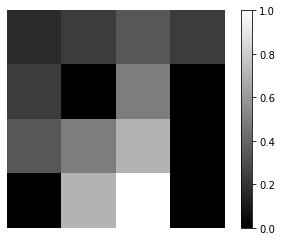

[[0.168 0.24  0.343 0.24 ]
 [0.24  0.    0.49  0.   ]
 [0.343 0.49  0.7   0.   ]
 [0.    0.7   1.    0.   ]]


In [ ]:
# only change the following line, to set parameters
q_table = Q_learning(env, alpha=.5, gamma=.7, epsilon=.5, episodes=10000)
display_value_function(q_table)

Describe the value function above. Do the numerical values in different states make sense? Why or why not? Explain.

It makes sense because in this value chart usually points closer to the final (reward==1) have larger value, and usually the points beside the hole have smaller value.

In [ ]:
# just run this cell
evaluate_Q_function(env, q_table)

Results after 1000 episodes:
Average steps per episode: 5.999
Chance of success: 0.999


Do the evaluate statistics make sense? How do they compare to the random environment below? Explain.

The evaluate statistics make sense because the average steps per episode is around 6 and there are only two shortest ways below.

In [ ]:
# just run this cell
frames = sample_episode(env, q_table)
print_frames(frames, delay=.1)

  (Right)
SFFF
FHFH
FFFH
HFFG

Timestep: 6
State: 5
Action: 2
Reward: 1.0


### Problem 2.3

Now use the function `Q_learning` on the random environment, 
where `is_slippery=True`. You may want to play around with this a bit 
to make sure you understand how it differs from the case where `is_slippery=False`.
The difference is that there is randomness in the state transitions for each 
action. If you try to go down, you may go right, for example.

As above, you run the following steps:

1. Create the environment
1. Run Q-learning. This is where you can experiment with different parameters
1. Display the value function `v(s) = np.max(q_table[s])`
1. Describe the value function, and how the numerical values make sense
1. Run `evaluate_Q_function` to get statistics on how well it works
1. Comment on the evaluation statistics
1. Print out a sample episode

The only line you need to change is the call to `Q_learning`, which is where you 
select the parameters. *Do not change the other cells*. You will be graded according 
to your implementation; these are checks to make sure it is working properly.

In [ ]:
# Do not change
random_env = gym.make("FrozenLake-v1", is_slippery=True)

100%|██████████| 100/100 [00:00<00:00, 3231.26it/s]


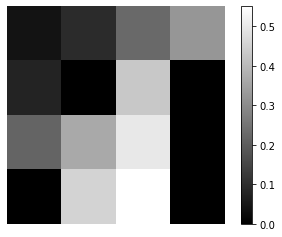

[[0.043 0.093 0.227 0.324]
 [0.076 0.    0.43  0.   ]
 [0.215 0.365 0.5   0.   ]
 [0.    0.455 0.55  0.   ]]


In [ ]:
# only change the following line, to set parameters
q_table = Q_learning(random_env, alpha=.1, gamma=.5, epsilon=.5, episodes=100)
display_value_function(q_table)

Describe the value function above. Do the numerical values in different states make sense? Why or why not? Explain.

Yes. Besides what have been discussed in non-slippery situation, the value at the corresponding point is much more smaller in slippery situation due to the randomness of the real action after you choose one action.

In [ ]:
# just run this cell
evaluate_Q_function(random_env, q_table)

Results after 1000 episodes:
Average steps per episode: 7.026
Chance of success: 0.002


Do the output statistics make sense? How do they compare to the deterministic environment?Explain.

Yes. It is possible to succeed in the random situation, but the probability is very low even if you have the optimal strategy.

In [ ]:
# just run this cell
frames = sample_episode(random_env, q_table)
print_frames(frames, delay=.1)

  (Down)
SFFF
FHFH
FFFH
HFFG

Timestep: 7
State: 5
Action: 1
Reward: 0.0


randomly exploration is very important in Q table updating. epsilon determines how often we makes a decision randomly instead of making the most optimal decision based on the current Q table so that we explore the environment. The if statement is just an easy way to facilitate the 10% exploration probability. If we generate a random number between 0 and 1, the mean probability that you get a number <0.1 is 0.1. 